## Setup

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold


## EDA

In [13]:
df = pd.read_csv('../data/tod-on-main.csv')

In [14]:
df = df.dropna(subset=['n_movers_out_Lowincome'])

In [15]:
df = df.dropna(subset=['n_stayers'])

In [16]:
df = df.dropna(subset=['n_stayers_Lowincome'])

## New Model EDA

In [17]:
y1 = df["n_movers_out"]
y2 = df["n_movers_out_Lowincome"]
y3 = df["n_movers_in"]
y4 = df["n_movers_in_Lowincome"]

In [18]:
before_df = df.filter(regex=r'^(Before)', axis=1)
after_df = df.filter(regex=r'^(After)', axis=1)

In [19]:
def calculating_average_bedrooms(df, before = True):
    word = "Before" if before else "After"
    null_rows = df[df[f"{word} Average number of bedrooms per dwelling"].isnull()]
    weighted_sum = (0.5 * null_rows[f"{word} 0 to 1 bedroom"] + 2 * null_rows[f"{word} 2 bedrooms"] + 3 * null_rows[f"{word} 3 bedrooms"] + 4.5 * null_rows[f"{word} 4 or more bedrooms"])
    total = (null_rows[[f"{word} 0 to 1 bedroom", f"{word} 2 bedrooms", f"{word} 3 bedrooms", f"{word} 4 or more bedrooms"]].sum(axis=1))
    null_rows[f"{word} Average number of bedrooms per dwelling"] = weighted_sum / total
    df.loc[null_rows.index, f"{word} Average number of bedrooms per dwelling"] = null_rows[f"{word} Average number of bedrooms per dwelling"]

In [20]:
calculating_average_bedrooms(before_df)
calculating_average_bedrooms(after_df, False)

/var/folders/qd/w0jg42cx76sc6s81d9zfb7t80000gn/T/ipykernel_2173/1411688805.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_rows[f"{word} Average number of bedrooms per dwelling"] = weighted_sum / total
/var/folders/qd/w0jg42cx76sc6s81d9zfb7t80000gn/T/ipykernel_2173/1411688805.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[null_rows.index, f"{word} Average number of bedrooms per dwelling"] = null_rows[f"{word} Average number of bedrooms per dwelling"]
/var/folders/qd/w0jg42cx76sc6s81d9zfb7t80000gn/T/ipykernel_2173/1411688805.py:6: SettingWithC

In [21]:
cols_to_drop = before_df.filter(regex='bedrooms?$', axis=1).columns
before_df = before_df.drop(columns = cols_to_drop)
cols_to_drop = after_df.filter(regex='bedrooms?$', axis=1).columns
after_df = after_df.drop(columns = cols_to_drop)

In [22]:
# Remove other dwelling and other single-attached (co-linearity) 
# & remove apartment (remove bedrooms, maybe add it back again later)

In [23]:
# Do we maybe even remove Dwellings since there is collinearity?

In [24]:
before_df = before_df.drop(["Before Apartment", "Before Other dwelling", "Before Other single-attached house"], axis=1)
after_df = after_df.drop(["After Other dwelling", "After Other attached dwelling", "After Other single-attached house"], axis=1)

## Adding original Population

In [25]:
# Can't even include this because there are missing values
original_population = df["n_movers_out"] + df["n_stayers"]
original_low_income_population = df["n_movers_out_Lowincome"] + df["n_stayers_Lowincome"]

## Missing Values

In [26]:
def impute_dwellings(df, before=True):
    word = "Before" if before else "After"
    df_known = df[df[f'{word} Dwellings'].notna()]
    df_missing = df[df[f'{word} Dwellings'].isna()]
    X_train = df_known[[f"{word} Total Occupied Private Dwellings", f"{word} Owned", f"{word} Rented"]]
    y_train = df_known[f"{word} Dwellings"]
    model = LinearRegression()
    model.fit(X_train, y_train)
    X_missing = df_missing[[f"{word} Total Occupied Private Dwellings", f"{word} Owned", f"{word} Rented"]]
    y_pred = model.predict(X_missing)
    df.loc[df[f'{word} Dwellings'].isna(), f'{word} Dwellings'] = y_pred

In [27]:
impute_dwellings(before_df)
impute_dwellings(after_df, False)

## Imputing with KNN

In [28]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [29]:
# These aren't great, but if I get rid of it it's only 3 rows that are removed

def kkn_imputation(df):
    scaler = StandardScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    imputer = KNNImputer(n_neighbors=3) 
    imputed_df = pd.DataFrame(imputer.fit_transform(scaled_df), columns=scaled_df.columns)
    return imputed_df

In [30]:
def standardize(df):
    scaler = StandardScaler()
    standardized_array = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(standardized_array, columns=df.columns)
    return scaled_df

In [31]:
before_imputed = kkn_imputation(before_df)
after_imputed = kkn_imputation(after_df)

In [32]:
combined_df = pd.concat([before_imputed,after_imputed], axis = 1)

In [33]:
before_imputed.columns = before_imputed.columns.str.replace(r'^\w+\s+', 'Change ', regex=True)
after_imputed.columns = after_imputed.columns.str.replace(r'^\w+\s+', 'Change ', regex=True)

In [34]:
difference_df = after_imputed - before_imputed

## Looking at Correlation

In [138]:
difference_corr = difference_df.copy()
before_imputed_corr = before_imputed.copy()
after_imputed_corr = after_imputed.copy()

difference_corr["n_movers_out_Lowincome"] = df["n_movers_out_Lowincome"]
before_imputed_corr["n_movers_out_Lowincome"] = df["n_movers_out_Lowincome"]
after_imputed_corr["n_movers_out_Lowincome"] = df["n_movers_out_Lowincome"]

In [139]:
corr = difference_corr.corr()['n_movers_out_Lowincome'].sort_values(ascending=False)
b_corr = before_imputed_corr.corr()['n_movers_out_Lowincome'].sort_values(ascending=False)
a_corr = after_imputed_corr.corr()['n_movers_out_Lowincome'].sort_values(ascending=False)

In [140]:
# Correlation of change columns
corr

n_movers_out_Lowincome                                         1.000000
Change Movable dwelling                                        0.285479
Change Owned                                                   0.204938
Change Population Density per square kilometre                 0.202096
Change Apartment, building that has fewer than five storeys    0.184620
Change Row house                                               0.105398
Change Total Occupied Private Dwellings                        0.087129
Change Dwellings                                               0.063002
Change Apartment, building that has five or more storeys       0.047699
Change Average number of bedrooms per dwelling                 0.046992
Change Semi-detached house                                     0.031979
Change Rented                                                 -0.068492
Change Apartment, duplex                                      -0.077175
Change Single-detached house                                  -0

In [141]:
# Correlation of "Before" columns
b_corr

n_movers_out_Lowincome                                         1.000000
Change Apartment, building that has fewer than five storeys    0.100600
Change Rented                                                  0.042811
Change Apartment, duplex                                       0.041267
Change Dwellings                                              -0.008453
Change Total Occupied Private Dwellings                       -0.027996
Change Apartment, building that has five or more storeys      -0.042971
Change Population Density per square kilometre                -0.068885
Change Average number of bedrooms per dwelling                -0.087703
Change Movable dwelling                                       -0.117739
Change Single-detached house                                  -0.162785
Change Owned                                                  -0.188954
Change Semi-detached house                                    -0.269776
Change Row house                                              -0

In [142]:
# Correlation of "After" columns
a_corr

n_movers_out_Lowincome                                         1.000000
Change Movable dwelling                                        0.252362
Change Apartment, building that has fewer than five storeys    0.164179
Change Population Density per square kilometre                 0.069765
Change Rented                                                  0.017839
Change Dwellings                                               0.014750
Change Total Occupied Private Dwellings                        0.012686
Change Apartment, duplex                                       0.007096
Change Average number of bedrooms per dwelling                -0.002490
Change Owned                                                  -0.004766
Change Apartment, building that has five or more storeys      -0.019806
Change Row house                                              -0.183899
Change Semi-detached house                                    -0.236705
Change Single-detached house                                  -0

## Preparing Training Data

In [35]:
combined_df["original_population"] = original_population.reset_index()[0]
combined_df["original_low_income_population"] = original_low_income_population.reset_index()[0]

In [36]:
combined_df_scaled = standardize(combined_df)

In [37]:
combined_df_scaled.columns

Index(['Before Population Density per square kilometre', 'Before Dwellings',
       'Before Total Occupied Private Dwellings',
       'Before Single-detached house', 'Before Semi-detached house',
       'Before Row house', 'Before Apartment, duplex',
       'Before Apartment, building that has fewer than five storeys',
       'Before Apartment, building that has five or more storeys',
       'Before Movable dwelling',
       'Before Average number of bedrooms per dwelling', 'Before Owned',
       'Before Rented', 'After Population Density per square kilometre',
       'After Dwellings', 'After Total Occupied Private Dwellings',
       'After Single-detached house', 'After Semi-detached house',
       'After Row house', 'After Apartment, duplex',
       'After Apartment, building that has fewer than five storeys',
       'After Apartment, building that has five or more storeys',
       'After Movable dwelling',
       'After Average number of bedrooms per dwelling', 'After Owned',
     

In [38]:
X = combined_df_scaled[["Before Population Density per square kilometre", 
             "Before Dwellings", 
             "Before Average number of bedrooms per dwelling", 
             "Before Apartment, building that has five or more storeys",
             "Before Total Occupied Private Dwellings",
             "After Population Density per square kilometre", 
             "After Dwellings", 
             "After Average number of bedrooms per dwelling", 
             "After Apartment, building that has five or more storeys",
             "After Total Occupied Private Dwellings", 'original_population',
       'original_low_income_population'
            ]]

In [39]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2)

## Ridge & Lasso Model

In [241]:
kf = KFold(n_splits=5, shuffle=True, random_state=53)  # 5 folds
model = Ridge()

mse_scores = []
r2_scores = []

for train_index, val_index in kf.split(X):
    # Split data
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y1.iloc[train_index], y1.iloc[val_index]

    # Train model
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mse_scores.append(mse)
    r2_scores.append(r2)

print("Mean MSE across folds:", sum(mse_scores) / len(mse_scores))
print("Mean R² across folds:", sum(r2_scores) / len(r2_scores))

Mean MSE across folds: 180947231.7469843
Mean R² across folds: 0.8267185446894662


In [269]:
model_r = Ridge()
model_r.fit(X_train, y_train)

Ridge()

In [270]:
y_pred = model_r.predict(X_test)

In [271]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)
print("Intercept:", model_r.intercept_)
print("Coefficients:", model_r.coef_)

Mean Squared Error (MSE): 21667393.642095298
R² Score: 0.9729548820073795
Intercept: 57526.86232052044
Coefficients: [-3750.40717905 -6739.73368398 -3715.15698934 -7579.45808294
  3146.15761129 12075.85470265  -271.35746331  1835.74411951
 -9909.26861234  4536.32644782 41038.77476655  4192.65835485]


In [218]:
model_l = Lasso(alpha=100, max_iter = 10000)
model_l.fit(X_train, y_train)

Lasso(alpha=100, max_iter=10000)

In [219]:
y_pred = model_l.predict(X_test)

In [220]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)
print("Intercept:", model_l.intercept_)
print("Coefficients:", model_l.coef_)

Mean Squared Error (MSE): 216383362.305774
R² Score: 0.053902571952767375
Intercept: 57572.98448238244
Coefficients: [-15613.75712127 -19192.78565499   -501.64531176  -3282.23504844
  13061.37069228  16369.56691968     -0.            687.53238174
  -3478.80981527      0.          49531.75156521  -2827.78493316]


## Decision Tree Regressor

In [221]:
from sklearn.tree import DecisionTreeRegressor


In [222]:
model_dt = DecisionTreeRegressor(max_depth=5)
model_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5)

In [223]:
y_pred = model_l.predict(X_test)

In [224]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)

Mean Squared Error (MSE): 216383362.305774
R² Score: 0.053902571952767375


## Random Forest

In [225]:
from sklearn.ensemble import RandomForestRegressor


In [226]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [227]:
y_pred = model_rf.predict(X_test)

In [228]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)

Mean Squared Error (MSE): 198918472.0965909
R² Score: 0.1302646708311731


## XGBoost


In [40]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y3, test_size=0.2)

In [41]:
from xgboost import XGBRegressor

In [42]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [43]:
y_pred = model_xgb.predict(X_test)

In [46]:
model_xgb.feature_importances_

array([4.5407992e-03, 1.3215077e-02, 3.0081226e-03, 6.6810627e-03,
       3.6571316e-02, 2.0632222e-02, 8.9175757e-03, 7.2101325e-02,
       3.9252695e-03, 2.8734296e-06, 8.1370473e-01, 1.6699607e-02],
      dtype=float32)

In [360]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)

Mean Squared Error (MSE): 172012736.0
R² Score: 0.799393892288208


## Secondary EDA

In [362]:
combined_df_scaled.columns

Index(['Before Population Density per square kilometre', 'Before Dwellings',
       'Before Total Occupied Private Dwellings',
       'Before Single-detached house', 'Before Semi-detached house',
       'Before Row house', 'Before Apartment, duplex',
       'Before Apartment, building that has fewer than five storeys',
       'Before Apartment, building that has five or more storeys',
       'Before Movable dwelling',
       'Before Average number of bedrooms per dwelling', 'Before Owned',
       'Before Rented', 'After Population Density per square kilometre',
       'After Dwellings', 'After Total Occupied Private Dwellings',
       'After Single-detached house', 'After Semi-detached house',
       'After Row house', 'After Apartment, duplex',
       'After Apartment, building that has fewer than five storeys',
       'After Apartment, building that has five or more storeys',
       'After Movable dwelling',
       'After Average number of bedrooms per dwelling', 'After Owned',
     

In [10]:
df["n_movers_out"].describe()

count        54.000000
mean      57421.481481
std       43995.976098
min        9790.000000
25%       26910.000000
50%       43772.500000
75%       68781.250000
max      206545.000000
Name: n_movers_out, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x168af0550>,
 'caps': [<matplotlib.lines.Line2D at 0x168af07d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x168acc2d0>],
 'medians': [<matplotlib.lines.Line2D at 0x168af0910>],
 'fliers': [<matplotlib.lines.Line2D at 0x168af0a50>],
 'means': []}

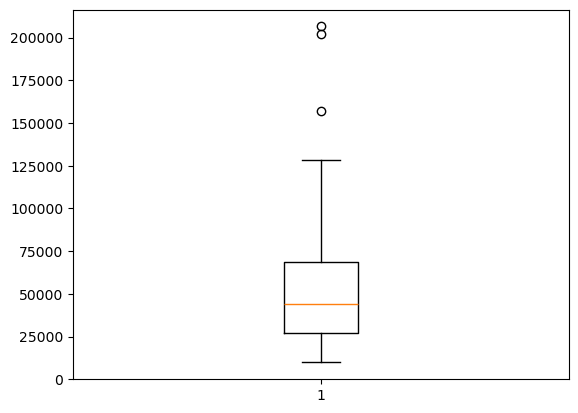

In [7]:
plt.boxplot(df["n_movers_out"])

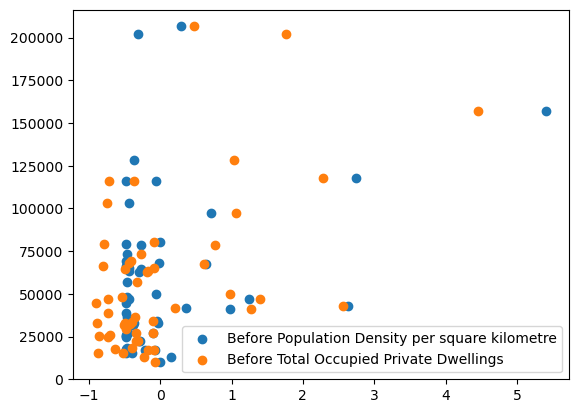

In [373]:
plt.scatter(combined_df_scaled["Before Population Density per square kilometre"], y1, label="Before Population Density per square kilometre")
plt.scatter(combined_df_scaled["Before Total Occupied Private Dwellings"], y1, label="Before Total Occupied Private Dwellings")
plt.legend()
plt.show()